In [13]:
import pandas as pd
import numpy as np
import math
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
from adjustText import adjust_text
import shap
import os
import scipy
from pathlib import Path
from sklearn.metrics import mean_squared_error

In [14]:
cwd = Path.cwd()
parent_dir = cwd.parent.parent

parent_dir

PosixPath('/home/veror/Desktop/Tweet2Geo')

1) model with dist^z -> in log: -z*log(dist)
2) model with exp(-dist/dist_0) -> in log: -z*dist where z = 1/dist_0

In [15]:
# choose if using all the data or the subset

data = 'all' # all, vatican, brexit, war, war_bre_vat

In [16]:
# DATA FOR FIT

# countr info dataset
country_info = pd.read_csv(parent_dir / 'Data' / 'Europe' / '0 gravity model' / 'country_stats.csv')

# population vector
country_pop = country_info['pop_2021'].to_numpy()

# GDP vector
country_gdp = country_info['GDP_2021'].to_numpy()

# GDP per capita vector
country_gdp_per_capita = (country_info['GDP_2021'] / country_info['pop_2021']).to_numpy()

In [18]:
# distances matrix
matrix_distance = pd.read_csv(parent_dir / 'Data' / 'Europe' / '0 gravity model' / 'distances centroids EU.csv')
matrix_distance = matrix_distance.drop(index=[0], columns=['lat_lon'])
matrix_distance = matrix_distance.apply(pd.to_numeric)
matrix_distance = matrix_distance.reset_index(drop=True)
matrix_distance.columns = matrix_distance.index

# countries pairs vector
migration_flows = pd.read_csv(parent_dir / 'Data' / 'Europe' / '0 gravity model' / 'matrix migr final.csv')
country_vector = []
for i in range(len(migration_flows)):
    for col in migration_flows.columns[1:]:
        country_vector.append(migration_flows.at[i, 'Unnamed: 0']+'-'+col)

# df for index
if data == 'all':
    df_flux_no_self = pd.read_csv(parent_dir / 'Data' / 'Europe' / 'matrix_fluxes_0.5_no_self_loops.csv')
else:
    file = data + '_flux.csv'
    df_flux_no_self = pd.read_csv(parent_dir / 'Data analysis' / 'Topics' / 'topics_flux' / 'EU' / file)#.drop(columns='Unnamed: 0')

### Model: gdp tot, distance, language, inverse migration

In [27]:
column1 = 'Source gdp'
column2 = 'Target gdp'
column3 = 'Distance'
column4 = 'Language'
column5 = 'Migration'
column6 = 'flux_percentage_05'

# results dataframe
res_df = pd.DataFrame()

# flows
if data == 'all':
    normalized_flows = pd.read_csv(parent_dir / 'Data' / 'Europe' / 'fluxes_0.5_norm_day_ok.csv')
else:
    file = data + '_norm_flux.csv'
    normalized_flows = pd.read_csv(parent_dir / 'Data analysis' / 'Topics' / 'topics_flux' / 'EU' / file)#.drop(columns=['Unnamed: 0'])
normalized_flows = normalized_flows.apply(pd.to_numeric)

# languages
lang_matrix = pd.read_csv(parent_dir / 'Data' / 'Europe' / '0 gravity model' / 'languages_matrix_dummies.csv')#.drop(columns=['Unnamed: 0'])
lang_matrix.columns = df_flux_no_self.index
lang_matrix.index = df_flux_no_self.index

# migration flows
matr_migr = pd.read_csv(parent_dir / 'Data' / 'Europe' / '0 gravity model' / 'matrix migr final trans.csv').drop(columns=['Unnamed: 0'])
matr_migr = matr_migr.fillna(-1)
matr_migr = matr_migr.replace(0, -1)
matr_migr.columns = df_flux_no_self.index
matr_migr.index = df_flux_no_self.index
matr_migr = matr_migr.apply(pd.to_numeric)

# create sub percentage flow vector
real_vector = []

# create vectors for columns
dist_vector = []
lang_vector = []
migr_vector = []
flow_vector = []
multiple_country_gdp = []
starting_gdp = np.repeat(country_gdp, 45)

for i in range(len(normalized_flows)):
    #print(i)

    dist_vector += list(matrix_distance.loc[i])
    lang_vector += list(lang_matrix.loc[i])
    migr_vector += list(matr_migr.loc[i])
    flow_vector += list(normalized_flows.loc[i])
    multiple_country_gdp += list(country_gdp)

df_plot = pd.DataFrame({column1: starting_gdp, column2: multiple_country_gdp, column3: dist_vector, column4: lang_vector, column5: migr_vector, column6: flow_vector})

sub_plot = df_plot[(df_plot['flux_percentage_05'] > 0) & (df_plot['Distance'] > 0) & (df_plot['Language'] != 'menouno') & (df_plot['Migration'] > 0)]
sub_plot = pd.get_dummies(data=sub_plot)

# create df for residuals plot without migration
residual_df = pd.DataFrame()
residual_df['Source gdp'] = sub_plot['Source gdp']
residual_df['Target gdp'] = sub_plot['Target gdp']
residual_df['Distance'] = sub_plot['Distance']
residual_df['Language_2'] = sub_plot['Language_2']
residual_df['Language_1'] = sub_plot['Language_1']
residual_df['Migration'] = sub_plot['Migration']

# model
real_vector = list(sub_plot['flux_percentage_05'])
sub_plot['flux_percentage_05'] = np.log10(sub_plot['flux_percentage_05'])
sub_plot['Source gdp'] = np.log10(sub_plot['Source gdp'])
sub_plot['Target gdp'] = np.log10(sub_plot['Target gdp'])
sub_plot['Distance'] = np.log10(sub_plot['Distance'])
sub_plot['Migration'] = np.log10(sub_plot['Migration'])
y = sub_plot['flux_percentage_05']
X = sub_plot.drop(columns=['flux_percentage_05'])
mod = LinearRegression()
mod.fit(X, y)
print('R squared', mod.score(X, y))
print('intercept', mod.intercept_)
print('coefficients', mod.coef_)
res_df = res_df._append({'R squared': mod.score(X, y), 'Intercept': mod.intercept_, 'Coefficient 1 (Source gdp)': mod.coef_[0], 'Coefficient 2 (Target gdp)': mod.coef_[1], 'Coefficient 3 (dist)': mod.coef_[2], 'Coefficient 4 (Migration)': mod.coef_[3], 'Coefficient 5.1 (Language_2)': mod.coef_[4], 'Coefficient 4.2 (Language_1)': mod.coef_[5],  'Normalization factor': -mod.intercept_, '# points per fit': len(sub_plot)}, ignore_index=True)
extimated_flux_log = mod.predict(X)
residual = y - extimated_flux_log
residual_df['residuals'] = residual
residual_df['y'] = y

# compute AIC
rss = np.sum((y - extimated_flux_log)**2)
n = len(y)
k = X.shape[1]
# mean square error
mse = mean_squared_error(y, extimated_flux_log)
# log likelihood
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - extimated_flux_log) ** 2)
# AIC and BIC calculations
aic_simpler = 2 * k - 2 * log_likelihood
bic_simpler = np.log(n) * k - 2 * log_likelihood
print('AIC', aic_simpler)
print('BIC', bic_simpler)

file = 'fit_g1_g2_d_lang_m_trans_' + data + '.csv'
res_df.to_csv(parent_dir / 'Data analysis' / 'Gravity model' / 'EU' / file)

R squared 0.6674669562863957
intercept -12.009832929866775
coefficients [ 0.63578986  0.33729641 -0.06455504  0.24173407  0.02714371 -0.02714371]
AIC 1708.8556975628721
BIC 1738.93379230071


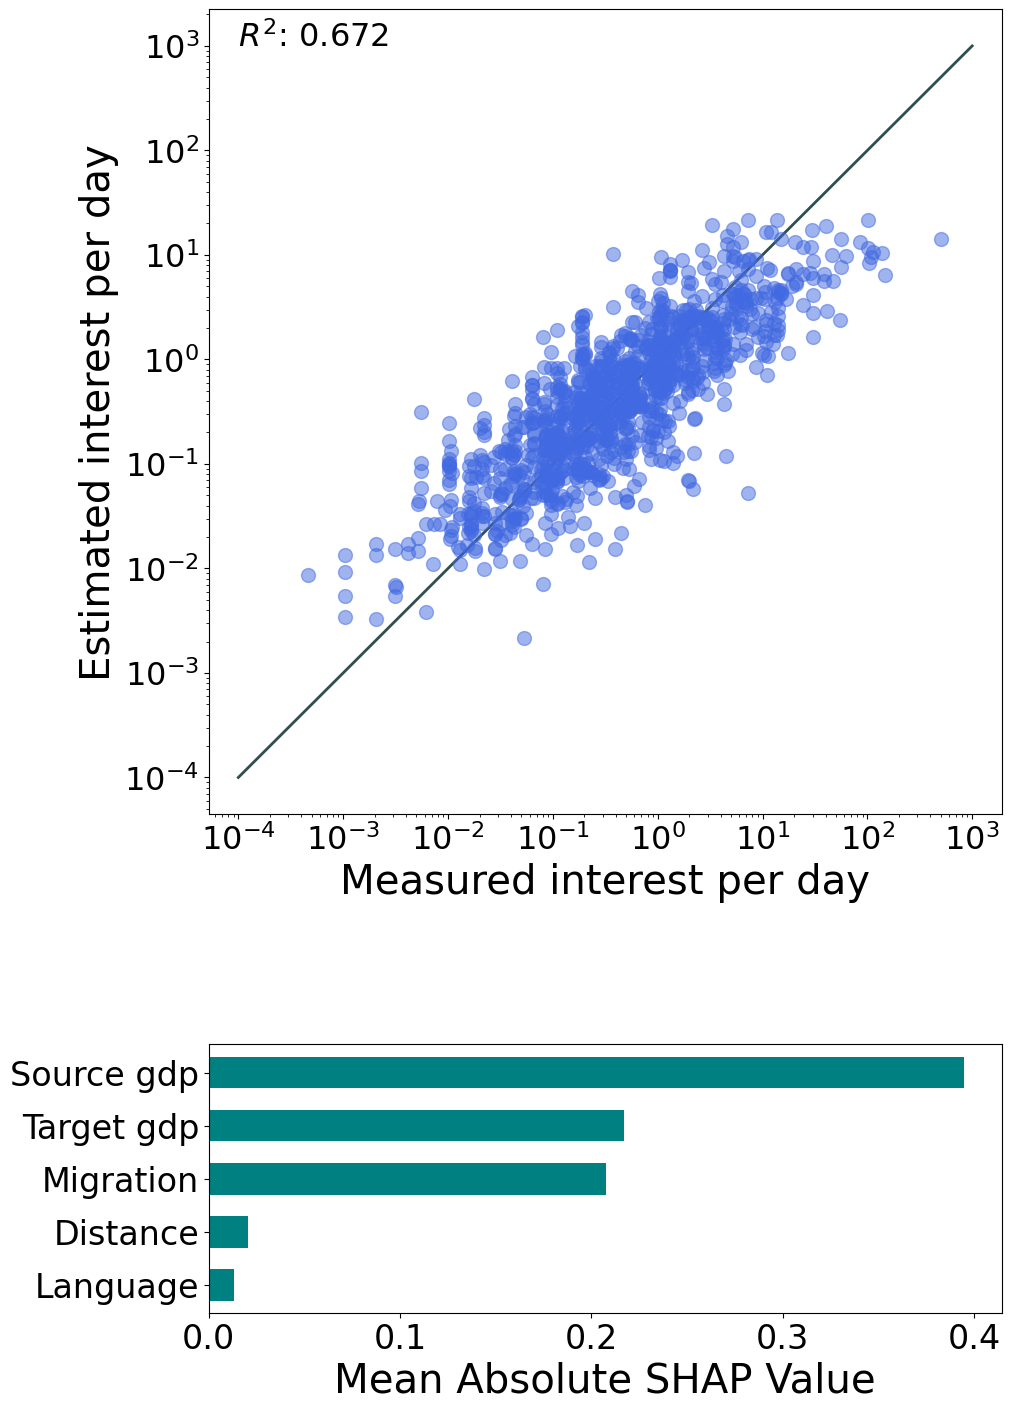

Index(['Source gdp', 'Target gdp', 'Migration', 'Distance', 'Language'], dtype='object')
[0.39471497899181907 0.21712955710128312 0.20765056008251317
 0.0203645993826366 0.01335159490374994]
Index(['Source gdp', 'Target gdp', 'Migration', 'Distance', 'Language_1',
       'Language_2'],
      dtype='object')


In [ ]:
# params
AREA = 'EU'
low_bound = 0.0001
high_bound = 1000
x = np.linspace(low_bound, high_bound, high_bound)

# shap values
masker = X  
explainer = shap.Explainer(mod, masker)
shap_values = explainer(X)
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)

# Compute mean absolute SHAP value per feature
shap_mean = shap_df.abs().mean().sort_values(ascending=False)

# Create figure
fig = plt.figure(figsize=(10, 14), constrained_layout=True)  

gs = fig.add_gridspec(nrows=18, ncols=1)  #)
ax1 = fig.add_subplot(gs[:12, 0])
ax2 = fig.add_subplot(gs[14:, 0])

# First subplot
ext_vector = 10 ** extimated_flux_log

ax1.plot(x, x, color='darkslategray', alpha=1, linewidth=2.0)
ax1.loglog(real_vector, ext_vector, '.', color='royalblue', alpha=0.5, markersize=20)

ax1.text(low_bound, high_bound, r'$R^{2}$: ' + str(round(mod.score(X, y), 3)), size=23)

ax1.set_xlabel('Measured interest per day', fontsize=29)
ax1.set_ylabel('Estimated interest per day', fontsize=29)
ax1.tick_params(axis='both', labelsize=23)
ax1.set_aspect('equal', adjustable='datalim')

# Second subplot
bar_width = 0.6
new_shap_mean_index = shap_mean.index[0:5]
new_shap_mean_values = shap_mean.values[0:5]
new_shap_mean_index_list = list(new_shap_mean_index)
new_shap_mean_index_list[4] = 'Language'
new_shap_mean_index = pd.Index(new_shap_mean_index_list)
#ax2.barh(shap_mean.index[::-1], shap_mean.values[::-1], color='teal', height=bar_width)
ax2.barh(new_shap_mean_index[::-1], new_shap_mean_values[::-1], color='teal', height=bar_width)


ax2.set_xlabel('Mean Absolute SHAP Value', fontsize=29)
ax2.tick_params(axis='both', labelsize=24)

#plt.tight_layout()
file = 'g1_g2_d_lang_m_trans_' + data + f'_gravity_model_{AREA}.pdf'
fig.savefig(parent_dir / 'Data analysis' / 'Gravity model' / 'EU' / file, transparent=True, dpi = 300)

plt.show()

### Model: population, gdp per capita, distance, language, inverse migration

In [ ]:
column1 = 'Source gdp capita'
column2 = 'Target gdp capita'
column3 = 'Source population'
column4 = 'Target population'
column5 = 'Distance'
column6 = 'Language'
column7 = 'Migration'
column8 = 'flux_percentage_05'

# results dataframe
res_df = pd.DataFrame()

# flows
if data == 'all':
    normalized_flows = pd.read_csv(parent_dir / 'Data' / 'Europe' / 'fluxes_0.5_norm_day_ok.csv')
else:
    file = data + '_norm_flux.csv'
    normalized_flows = pd.read_csv(parent_dir / 'Data analysis' / 'Topics' / 'topics_flux' / 'EU' / file)#.drop(columns=['Unnamed: 0'])
normalized_flows = normalized_flows.apply(pd.to_numeric)

# languages
lang_matrix = pd.read_csv(parent_dir / 'Data' / 'Europe' / '0 gravity model' / 'languages_matrix_dummies.csv')#.drop(columns=['Unnamed: 0'])
lang_matrix.columns = df_flux_no_self.index
lang_matrix.index = df_flux_no_self.index

# migration flows
matr_migr = pd.read_csv(parent_dir / 'Data' / 'Europe' / '0 gravity model' / 'matrix migr final trans.csv').drop(columns=['Unnamed: 0'])
matr_migr = matr_migr.fillna(-1)
matr_migr = matr_migr.replace(0, -1)
matr_migr.columns = df_flux_no_self.index
matr_migr.index = df_flux_no_self.index
matr_migr = matr_migr.apply(pd.to_numeric)

# create sub percentage flow vector
real_vector = []

# create vectors for columns
dist_vector = []
lang_vector = []
migr_vector = []
flow_vector = []
multiple_country_gdp = []
starting_gdp = np.repeat(country_gdp_per_capita, 45)
multiple_country_pop = []
starting_pop = np.repeat(country_pop, 45)

for i in range(len(normalized_flows)):
    #print(i)

    dist_vector += list(matrix_distance.loc[i])
    lang_vector += list(lang_matrix.loc[i])
    migr_vector += list(matr_migr.loc[i])
    flow_vector += list(normalized_flows.loc[i])
    multiple_country_gdp += list(country_gdp_per_capita)
    multiple_country_pop += list(country_pop)
    

df_plot = pd.DataFrame({column1: starting_gdp, column2: multiple_country_gdp, column3: starting_pop, column4: multiple_country_pop, column5: dist_vector, column6: lang_vector, column7: migr_vector, column8: flow_vector})

sub_plot = df_plot[(df_plot['flux_percentage_05'] > 0) & (df_plot['Distance'] > 0) & (df_plot['Language'] != 'menouno') & (df_plot['Migration'] > 0)]
sub_plot = pd.get_dummies(data=sub_plot)

# create df for residuals plot without migration
'''residual_df = pd.DataFrame()
residual_df['Source gdp capita'] = sub_plot['Source gdp capita']
residual_df['Target gdp capita'] = sub_plot['Target gdp capita']
residual_df['Distance'] = sub_plot['Distance']
residual_df['Language_2'] = sub_plot['Language_2']
residual_df['Language_1'] = sub_plot['Language_1']
residual_df['Migration'] = sub_plot['Migration']'''

# model
real_vector = list(sub_plot['flux_percentage_05'])
sub_plot['flux_percentage_05'] = np.log10(sub_plot['flux_percentage_05'])
sub_plot['Source gdp capita'] = np.log10(sub_plot['Source gdp capita'])
sub_plot['Target gdp capita'] = np.log10(sub_plot['Target gdp capita'])
sub_plot['Source population'] = np.log10(sub_plot['Source population'])
sub_plot['Target population'] = np.log10(sub_plot['Target population'])
sub_plot['Distance'] = np.log10(sub_plot['Distance'])
sub_plot['Migration'] = np.log10(sub_plot['Migration'])
y = sub_plot['flux_percentage_05']
X = sub_plot.drop(columns=['flux_percentage_05'])

mod = LinearRegression()
mod.fit(X, y)
print('R squared', mod.score(X, y))
print('intercept', mod.intercept_)
print('coefficients', mod.coef_)
res_df = res_df._append({'R squared': mod.score(X, y), 'Intercept': mod.intercept_, 'Coefficient 1 (Source gdp)': mod.coef_[0], 'Coefficient 2 (Target gdp)': mod.coef_[1], 'Coefficient 3 (Source population)': mod.coef_[2], 'Coefficient 4 (Target population)': mod.coef_[3], 'Coefficient 5 (dist)': mod.coef_[4], 'Coefficient 6 (Migration)': mod.coef_[5], 'Coefficient 7.1 (Language_2)': mod.coef_[6], 'Coefficient 7.2 (Language_1)': mod.coef_[7],  'Normalization factor': -mod.intercept_, '# points per fit': len(sub_plot)}, ignore_index=True)
extimated_flux_log = mod.predict(X)
residual = y - extimated_flux_log
residual_df['residuals'] = residual
residual_df['y'] = y



# compute AIC
rss = np.sum((y - extimated_flux_log)**2)
n = len(y)
k = X.shape[1]
# mean square error
mse = mean_squared_error(y, extimated_flux_log)
# log likelihood
log_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - extimated_flux_log) ** 2)
# AIC and BIC calculations
aic_complex = 2 * k - 2 * log_likelihood
bic_complex = np.log(n) * k - 2 * log_likelihood
print('AIC', aic_complex)
print('BIC', bic_complex)

file = 'fit_p1_p2_g1_g2_d_lang_m_trans_' + data + '.csv'
res_df.to_csv(parent_dir / 'Data analysis' / 'Gravity model' / 'EU' / file)



R squared 0.6754749763041675
intercept -11.467812293599811
coefficients [ 0.49453871  0.24873483  0.68419385  0.37195002 -0.06085292  0.21527313
  0.04453478 -0.04453478]
AIC 1685.7733094593723
BIC 1725.8774357764894


"# compute AIC\nrss = np.sum((y - extimated_flux_log )**2)\nn = len(y)\nk = X.shape[1]\naic_complex = n * np.log(rss / n) + 2 * k\nprint('AIC', aic_complex)\n\n\nY = y\nest_Y = extimated_flux_log\nmse = mean_squared_error(Y, est_Y)\nlog_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((Y - est_Y) ** 2)\n# AIC and BIC calculations\naic_complex = 2 * k - 2 * log_likelihood\nbic_complex = np.log(n) * k - 2 * log_likelihood\nprint('AIC', aic_complex)\nprint('BIC', bic_complex)\n\n\nY = 10**y\nest_Y = 10**extimated_flux_log\nmse = mean_squared_error(y, extimated_flux_log)\nlog_likelihood = -n / 2 * np.log(2 * np.pi * mse) - (1 / (2 * mse)) * np.sum((y - extimated_flux_log) ** 2)\n# AIC and BIC calculations\naic_complex = 2 * k - 2 * log_likelihood\nbic_complex = np.log(n) * k - 2 * log_likelihood\nprint('AIC', aic_complex)\nprint('BIC', bic_complex)"

Index(['Source population', 'Target population', 'Migration',
       'Source gdp capita', 'Target gdp capita', 'Language_2', 'Language_1',
       'Distance'],
      dtype='object')
['Source population', 'Target population', 'Migration', 'Source gdp capita', 'Target gdp capita', 'Language_1', 'Distance']


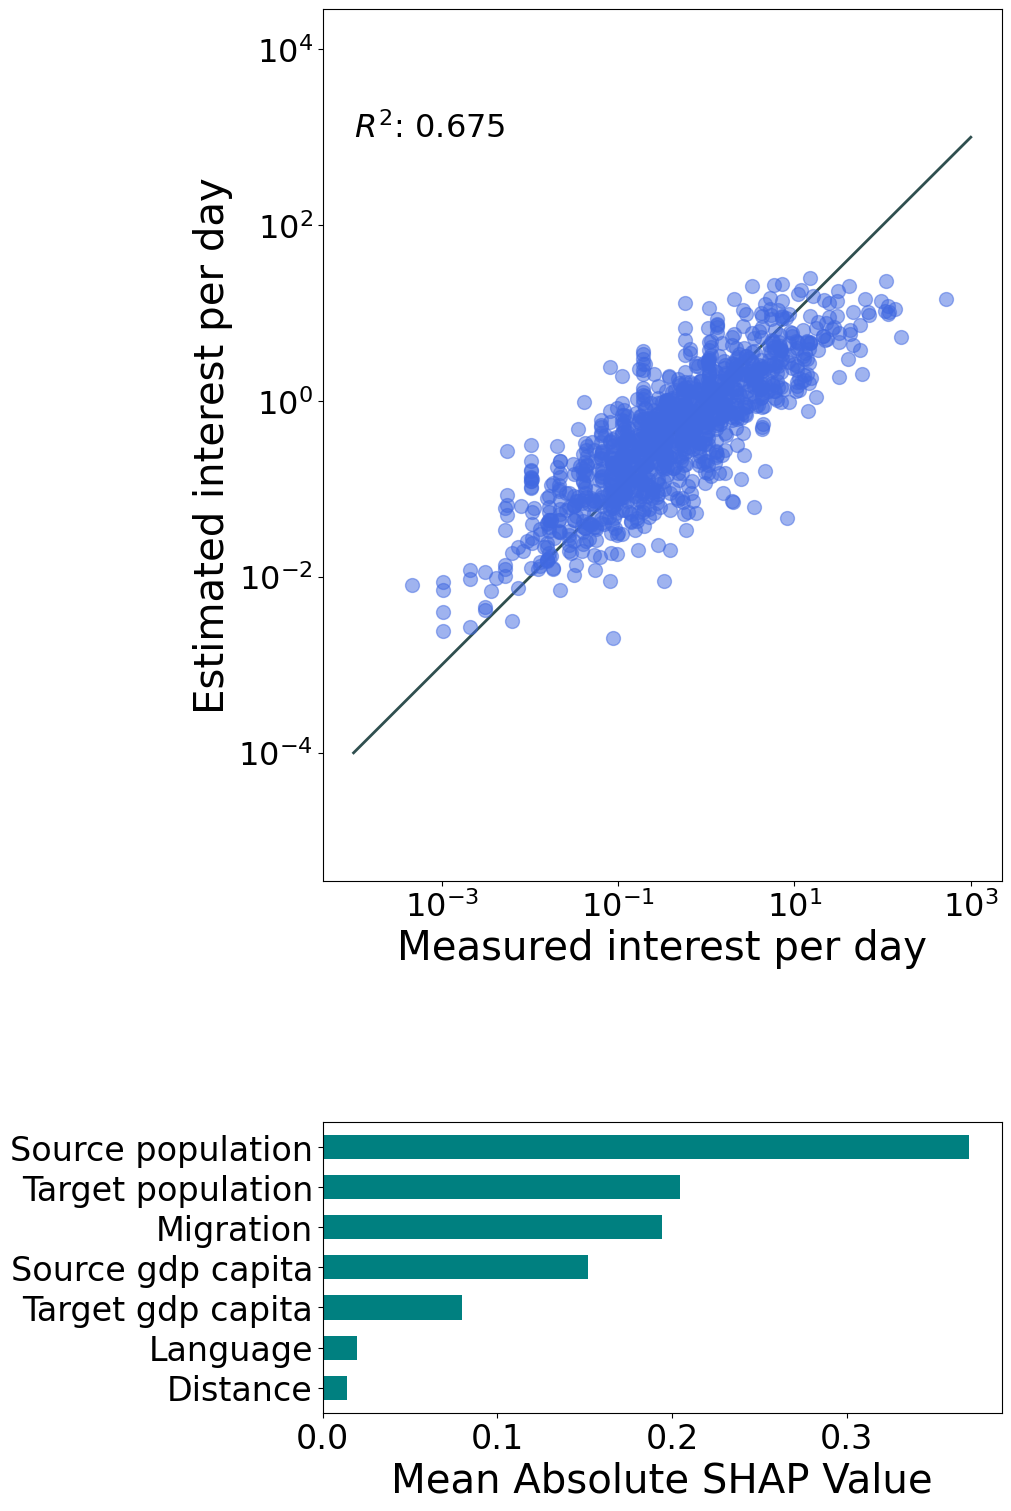

Index(['Source population', 'Target population', 'Migration',
       'Source gdp capita', 'Target gdp capita', 'Language', 'Distance'],
      dtype='object')
Index([ 0.37026796456857825,  0.20430539046548277,  0.19451842168616232,
        0.15207850144182536,   0.0795738705729675, 0.019475047077895304,
       0.013998745595804156],
      dtype='float64')
Index(['Source population', 'Target population', 'Migration',
       'Source gdp capita', 'Target gdp capita', 'Language_2', 'Language_1',
       'Distance'],
      dtype='object')


In [ ]:
# params
AREA = 'EU'
low_bound = 0.0001
high_bound = 1000
x = np.linspace(low_bound, high_bound, high_bound)
low_bound_y = 0.001
high_bound_y = 100

# shap values
masker = X  
explainer = shap.Explainer(mod, masker)
shap_values = explainer(X)
shap_df = pd.DataFrame(shap_values.values, columns=X.columns)

# Compute mean absolute SHAP value per feature
shap_mean = shap_df.abs().mean().sort_values(ascending=False)

# Create figure
fig = plt.figure(figsize=(10, 15), constrained_layout=True)  

gs = fig.add_gridspec(nrows=18, ncols=1)  #)
ax1 = fig.add_subplot(gs[:12, 0])
ax2 = fig.add_subplot(gs[14:, 0])

# First subplot
ext_vector = 10 ** extimated_flux_log

ax1.plot(x, x, color='darkslategray', alpha=1, linewidth=2.0)
ax1.loglog(real_vector, ext_vector, '.', color='royalblue', alpha=0.5, markersize=20)

ax1.set_ylim(low_bound_y, high_bound_y)
ax1.text(low_bound, high_bound, r'$R^{2}$: ' + str(round(mod.score(X, y), 3)), size=23)

ax1.set_xlabel('Measured interest per day', fontsize=29)
ax1.set_ylabel('Estimated interest per day', fontsize=29)
ax1.tick_params(axis='both', labelsize=23)
ax1.set_aspect('equal', adjustable='datalim')

# Second subplot
bar_width = 0.6
new_shap_mean_index = shap_mean.index[0:8]
new_shap_mean_values = shap_mean.values[0:8]
print(new_shap_mean_index)
new_shap_mean_index_list = list(new_shap_mean_index)
new_shap_mean_values_list = list(new_shap_mean_values)
new_shap_mean_index_list = new_shap_mean_index_list[:5] + new_shap_mean_index_list[6:9]
new_shap_mean_values_list = new_shap_mean_values_list[:5] + new_shap_mean_values_list[6:9]
print(new_shap_mean_index_list)

new_shap_mean_index_list[5] = 'Language'
new_shap_mean_index = pd.Index(new_shap_mean_index_list)
new_shap_mean_values = pd.Index(new_shap_mean_values_list)
#ax2.barh(shap_mean.index[::-1], shap_mean.values[::-1], color='teal', height=bar_width)
ax2.barh(new_shap_mean_index[::-1], new_shap_mean_values[::-1], color='teal', height=bar_width)


ax2.set_xlabel('Mean Absolute SHAP Value', fontsize=29)
ax2.tick_params(axis='both', labelsize=24)

#plt.tight_layout()
file = 'p1_p2_g1_g2_d_lang_m_trans_' + data + f'_gravity_model_{AREA}_new.png'
fig.savefig(parent_dir / 'Data analysis' / 'Gravity model' / 'EU' / file, transparent=False, dpi = 300)

plt.show()

In [12]:
df = pd.read_csv(parent_dir / 'Data' / 'Europe' / '0 gravity model' / 'languages_matrix_dummies_NO_FAMILY.csv')
df[:] = 2
df.to_csv(parent_dir / 'Data' / 'Europe' / '0 gravity model' / 'languages_matrix_dummies_NO_FAMILY_NEW.csv', index=False)